<a href="https://colab.research.google.com/github/rizalpangestu1/Machine-Learning/blob/main/GymLens_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Dataset directory
DATASET_DIR = '/content/drive/MyDrive/C242-PS284/Gym Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Function to list classes and count images
def list_classes_and_counts(data_dir):
    """
    List all classes in the dataset and count the number of images in each class.
    """
    try:
        classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
        class_counts = {}

        for cls in classes:
            cls_path = os.path.join(data_dir, cls)
            image_count = len([entry for entry in os.scandir(cls_path) if entry.is_file()])
            class_counts[cls] = image_count
            print(f"Class '{cls}' has {image_count} images.")

        total_images = sum(class_counts.values())
        print(f"\nTotal classes: {len(classes)}")
        print(f"Total images in the dataset: {total_images}")
        return class_counts
    except Exception as e:
        print(f"Error: {e}")
        return {}

# Function to display sample images
def display_sample_images(data_dir, max_classes=19):
    """
    Display one sample image from each class in the dataset.
    """
    try:
        classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
        plt.figure(figsize=(15, 10))

        for i, cls in enumerate(classes[:max_classes]):
            cls_path = os.path.join(data_dir, cls)
            if os.path.isdir(cls_path):
                image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
                if image_files:
                    image_path = os.path.join(cls_path, image_files[0])
                    img = Image.open(image_path)

                    plt.subplot(4, 5, i + 1)
                    plt.imshow(img)
                    plt.title(cls)
                    plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error displaying images: {e}")

Class 'Recumbent Bike' has 167 images.
Class 'Smith Machine' has 49 images.
Class 'Dumbell' has 270 images.
Class 'Elliptical Machine' has 454 images.
Class 'Bench Press' has 613 images.
Class 'Stair climber' has 100 images.
Class 'Treadmill' has 100 images.

Total classes: 7
Total images in the dataset: 1753


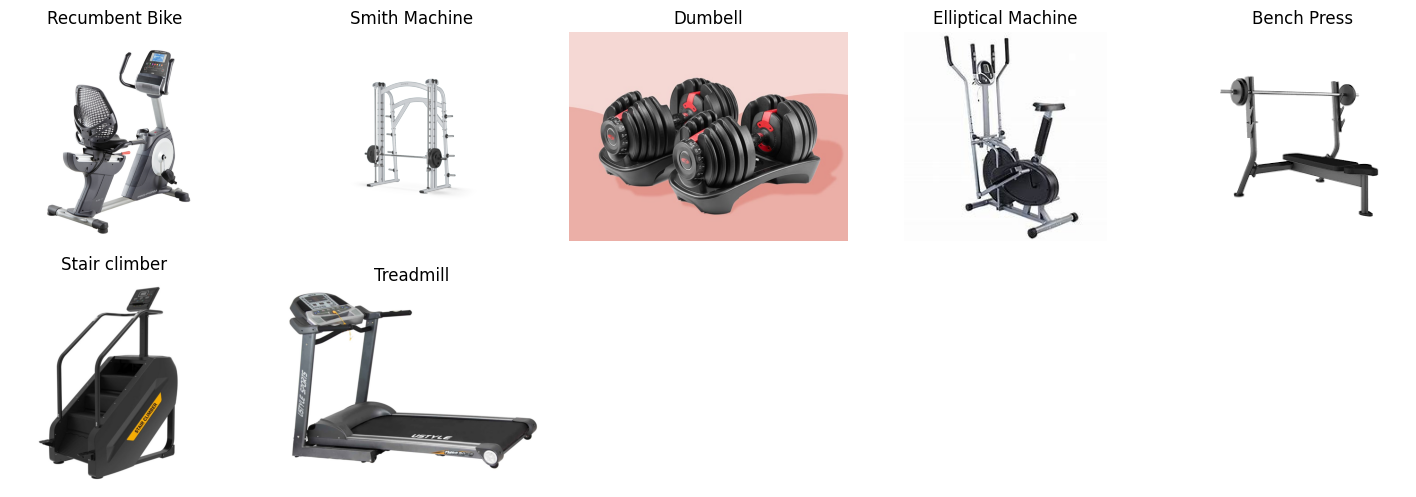

In [4]:
# List classes and display sample images
class_counts = list_classes_and_counts(DATASET_DIR)
display_sample_images(DATASET_DIR)

In [5]:
def preprocess_image(image_path):
    """
    Opens an image, converts it to RGBA format if needed, and returns the processed image.
    """
    img = Image.open(image_path)
    if img.mode in ('P', 'L') or ('transparency' in img.info):
        img = img.convert('RGBA')  # Convert to RGBA if it's palette-based or grayscale
    return img

In [6]:
def display_sample_images(data_dir, max_classes=19):
    """
    Display one sample image from each class in the dataset.
    """
    try:
        classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
        plt.figure(figsize=(15, 10))

        for i, cls in enumerate(classes[:max_classes]):
            cls_path = os.path.join(data_dir, cls)
            if os.path.isdir(cls_path):
                image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
                if image_files:
                    image_path = os.path.join(cls_path, image_files[0])
                    img = preprocess_image(image_path)

                    plt.subplot(4, 5, i + 1)
                    plt.imshow(img)
                    plt.title(cls)
                    plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error displaying images: {e}")


In [7]:
# Define image generators
batch_size = 128
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=100,
    class_mode='categorical',
    subset='validation'
)

print("Number of classes:", len(train_generator.class_indices))
print("Number of training data:", train_generator.n)
print("Number of validation data:", validation_generator.n)

Found 1404 images belonging to 7 classes.
Found 347 images belonging to 7 classes.
Number of classes: 7
Number of training data: 1404
Number of validation data: 347


In [8]:
# Define model
def create_model(input_shape=(224, 224, 3), num_classes=7):
    """
    Create a CNN model for multi-class classification.
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_model(input_shape=(224, 224, 3), num_classes=len(train_generator.class_indices))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      22,151,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,178,855 (84.61 MB)

 Trainable params: 22,178,855 (84.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# EarlyStoppingCallback for accuracy >= 98%
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nStopping training as validation accuracy reached {val_acc:.2f} (≥ {self.target_accuracy:.2f})")
            self.model.stop_training = True

early_stopping = EarlyStoppingAtAccuracy(target_accuracy=0.98)

In [11]:
# Train the model
epochs = 20
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 434s 24s/step - accuracy: 0.2114 - loss: 7.2845 - val_accuracy: 0.3516 - val_loss: 1.8429
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 162s 10s/step - accuracy: 0.4825 - loss: 1.5592 - val_accuracy: 0.4669 - val_loss: 1.5187
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 198s 10s/step - accuracy: 0.5994 - loss: 1.2212 - val_accuracy: 0.4640 - val_loss: 1.6415
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 148s 10s/step - accuracy: 0.6318 - loss: 1.0787 - val_accuracy: 0.4928 - val_loss: 1.7387
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 205s 10s/step - accuracy: 0.6399 - loss: 1.0481 - val_accuracy: 0.5159 - val_loss: 1.7447
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 149s 10s/step - accuracy: 0.6574 - loss: 1.0217 - val_accuracy: 0.5187 - val_loss: 1.6794
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 199s 10s/step - accuracy: 0.6679 - loss: 0.9358 - val_accuracy: 0.5159 - val_loss: 1.7362
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 211s 11s/step - accuracy: 0.6533 - loss: 0.9649 - val_accuracy: 0.5389 - val_

In [12]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.6060 - loss: 1.7962
Validation Loss: 1.932059645652771
Validation Accuracy: 0.579250693321228


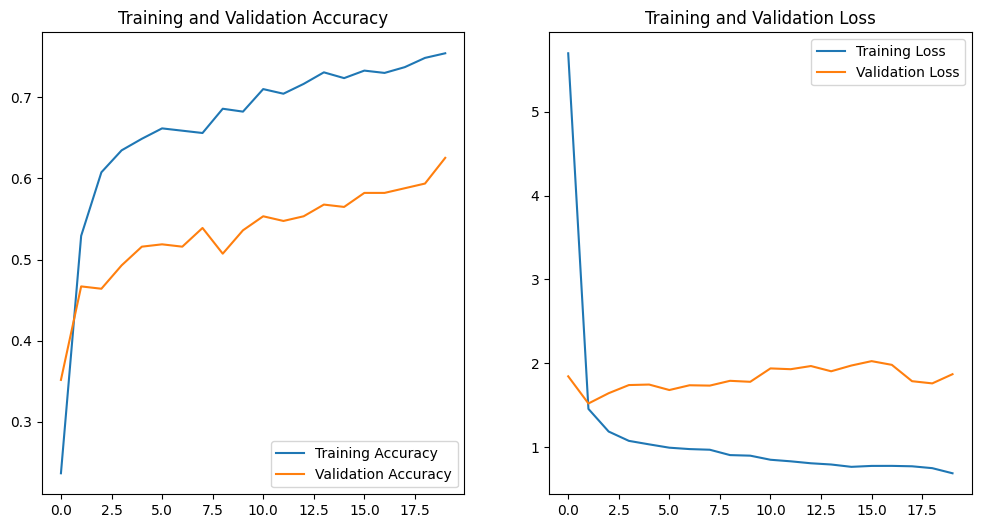

In [13]:
# Plot training and validation accuracy/loss
def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss over epochs.
    """
    # Extract data from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot the training history
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


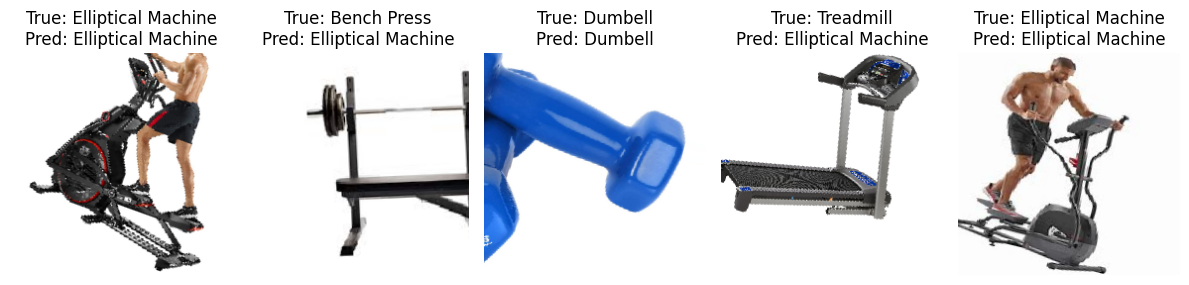

In [14]:
# Test with some validation images
def test_model_with_sample_images(validation_generator, model, num_samples=5):
    """
    Display predictions on sample validation images along with true labels.
    """
    # Get a batch of images and labels from the validation set
    images, labels = next(validation_generator)

    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = images[i]
        label = labels[i]

        # Predict the class of the image
        prediction = model.predict(img.reshape(1, *img.shape))
        predicted_label = list(validation_generator.class_indices.keys())[prediction.argmax()]
        true_label = list(validation_generator.class_indices.keys())[label.argmax()]

        # Display the image with the predicted and true labels
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on sample images
test_model_with_sample_images(validation_generator, model)

In [19]:
# Save the model
model_save_path = '/content/drive/MyDrive/C242-PS284/saved_model/my_gym_model_cnn.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/C242-PS284/saved_model/my_gym_model_cnn.h5
